In [2]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [3]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

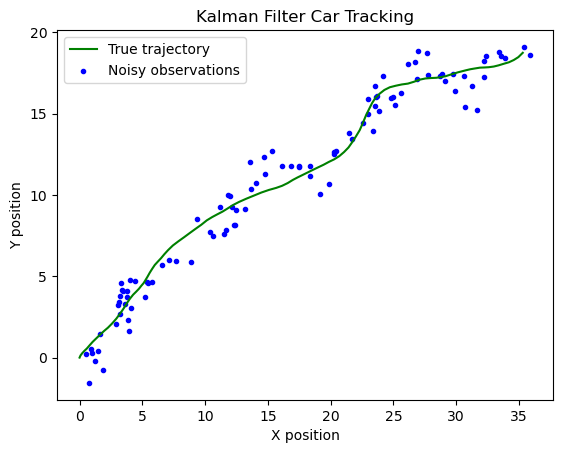

In [4]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [5]:
# Extended KF filtering
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_EKF = [m]
P_EKF = [P]

for y in noisy_observations[1:]:
    F = F_jacobian(m)
    m_pred = f(m)
    P_pred = F @ P @ F.T + Q
    
    H = H_jacobian(m_pred)
    
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - h(m_pred))
    P = P_pred - K @ S @ K.T
        
    P_EKF.append(P)
    estimated_trajectory_EKF.append(m)

P_EKF = np.array(P_EKF)
estimated_trajectory_EKF = np.array(estimated_trajectory_EKF)

In [6]:
# Extended RTS smoother
n, dim_x = estimated_trajectory_EKF.shape

estimated_trajectory_ERTS, P_ERTS = estimated_trajectory_EKF.copy(), P_EKF.copy()

for k in range(n-2,-1,-1):
    F = F_jacobian(m)
    m_pred = f(estimated_trajectory_ERTS[k])
    P_pred = F @ P_ERTS[k] @ F.T + Q
    G = P_ERTS[k] @ F.T @ np.linalg.inv(P_pred)
    estimated_trajectory_ERTS[k] += G @ (estimated_trajectory_ERTS[k+1] - m_pred)
    P_ERTS[k] += (G @ (P_ERTS[k+1] - P_pred)) @ G.T

In [10]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

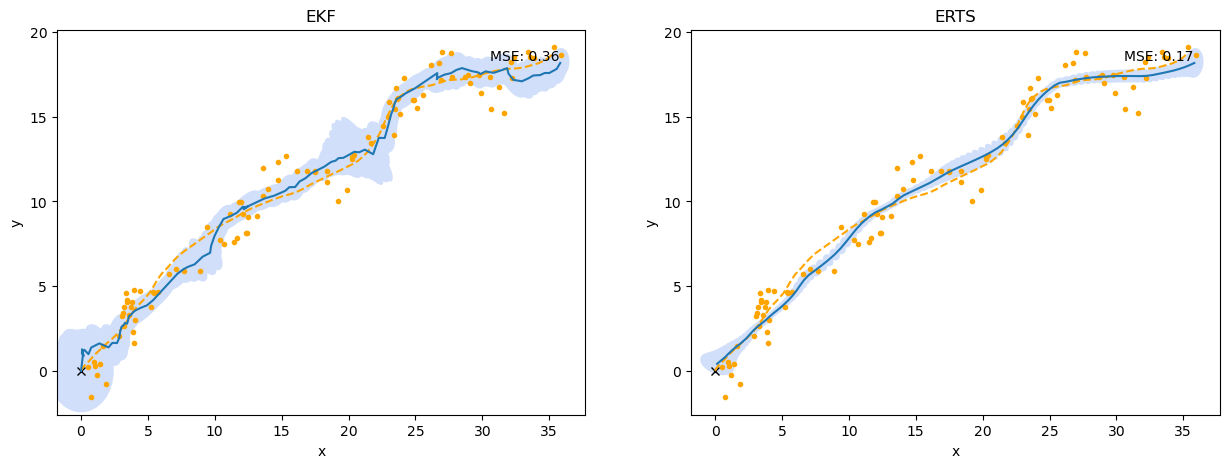

In [13]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_EKF[:, 0], estimated_trajectory_EKF[:, 1], label="KF")  
ax[0].set_title("EKF")

ax[1].plot(estimated_trajectory_ERTS[:, 0], estimated_trajectory_ERTS[:, 1], label="UKF (builtin 2)")
ax[1].set_title("ERTS")

# Compute MSE
EKF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_EKF[:, :2])**2)
ERTS_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_ERTS[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(EKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(ERTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

# # 95% confidence ellipses for the KF
for i in range(0, len(estimated_trajectory_EKF)):
    conf_ellipse(ax[0], estimated_trajectory_EKF[i, :2], P_EKF[i, :2, :2])
    
# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_ERTS)):
    conf_ellipse(ax[1], estimated_trajectory_ERTS[i, :2], P_ERTS[i, :2, :2])
    
plt.show()

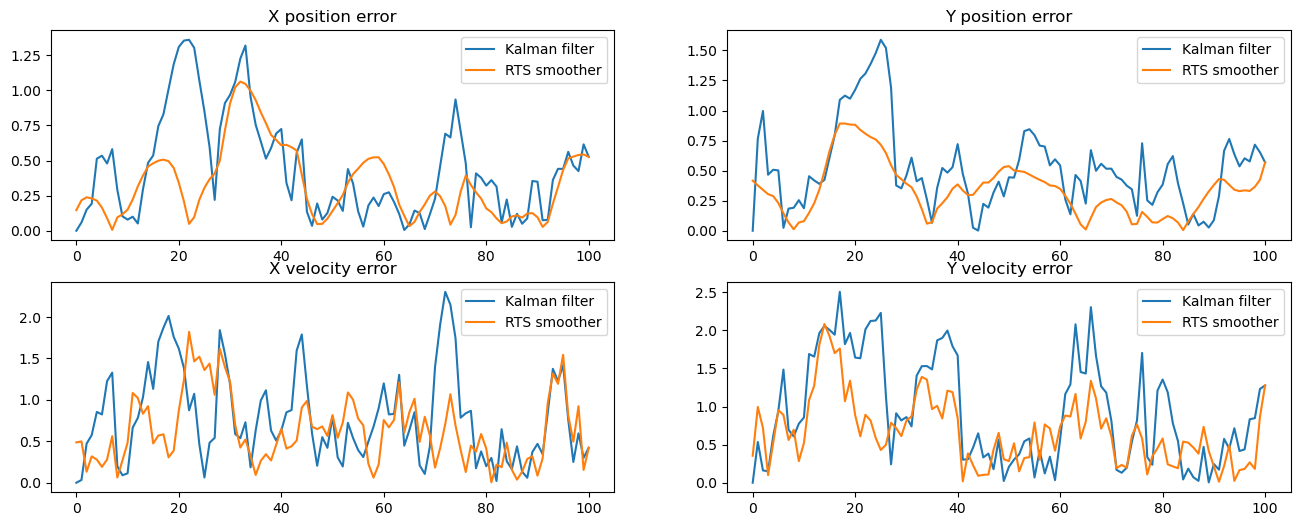

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax = ax.flatten()
    
ax[0].plot(np.abs(true_trajectory[:, 0] - estimated_trajectory_EKF[:, 0]), label="Kalman filter")
ax[0].plot(np.abs(true_trajectory[:, 0] - estimated_trajectory_ERTS[:, 0]), label="RTS smoother")
ax[0].set_title('X position error')
ax[0].legend()

ax[1].plot(np.abs(true_trajectory[:, 1] - estimated_trajectory_EKF[:, 1]), label="Kalman filter")
ax[1].plot(np.abs(true_trajectory[:, 1] - estimated_trajectory_ERTS[:, 1]), label="RTS smoother")
ax[1].set_title('Y position error')
ax[1].legend()

ax[2].plot(np.abs(true_trajectory[:, 2] - estimated_trajectory_EKF[:, 2]), label="Kalman filter")
ax[2].plot(np.abs(true_trajectory[:, 2] - estimated_trajectory_ERTS[:, 2]), label="RTS smoother")
ax[2].set_title('X velocity error')
ax[2].legend()

ax[3].plot(np.abs(true_trajectory[:, 3] - estimated_trajectory_EKF[:, 3]), label="Kalman filter")
ax[3].plot(np.abs(true_trajectory[:, 3] - estimated_trajectory_ERTS[:, 3]), label="RTS smoother")
ax[3].set_title('Y velocity error')
ax[3].legend()
plt.show()